In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve,precision_score, recall_score, confusion_matrix, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from boruta import BorutaPy

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from keras import Sequential
from keras.src.layers import Dense, Dropout
from keras.src.optimizers import Adam
from keras.src.callbacks import EarlyStopping

## Data prep

In [2]:
# Load data
data = pd.read_csv('C:/Users/danie/OneDrive/Documentos/1 UNIANDES/10 semestre/Tesis/differential-privacy-banking-sector/data/processed/bank-processed.csv', sep=',')
data.shape

(45211, 33)

In [3]:
# Separate features and target variable
X = data.drop(columns=['y'])
Y = data['y']

### MinMax Scaler

In [4]:
# Define numerical features
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Normalize numerical features
scale = MinMaxScaler()
X[numeric_cols] = scale.fit_transform(X[numeric_cols])

In [5]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

#### SMOTE-EEN (Minority Over-sampling Technique combined with Edited Nearest Neighbors)

In [6]:
stat = pd.DataFrame(Y.value_counts())
stat['percent'] = stat['count']/Y.shape[0]*100
stat

,count,percent
y,,
0,39922,88.30152
1,5289,11.69848


In [7]:
# Crear el objeto SMOTEENN
smoteenn = SMOTEENN(random_state=42)

# Aplicar la resampleación
X_resample, y_resample = smoteenn.fit_resample(X_train, y_train)

# Convertir a DataFrame para mantener nombres de columnas
X_resample = pd.DataFrame(X_resample, columns=X.columns)
y_resample = pd.Series(y_resample)


In [8]:
stat2 = pd.DataFrame(y_resample.value_counts())
stat2['percent'] = stat2['count']/y_resample.shape[0]*100
stat2

,count,percent
y,,
1,27937,52.214788
0,25567,47.785212


### Feature Selection


In [10]:
# Inicializar el modelo de XGBoost asegurando compatibilidad
rf = xgb.XGBClassifier(eval_metric='logloss')

# Configurar BorutaPy
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42)

# Ajustar BorutaPy asegurando que Y_resample sea 1D
feat_selector.fit(X_resample.values, y_resample.values.ravel())

# Obtener las características seleccionadas
X_filtered = X.columns[feat_selector.support_].tolist()

In [11]:
X_filtered

['age',
 'balance',
 'housing',
 'loan',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_unemployed',
 'marital_married',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'contact_telephone',
 'contact_unknown',
 'poutcome_success',
 'poutcome_unknown']

In [12]:
len(X_filtered)

26

## Hyperparameter Tuning

In [ ]:
# Definir modelos
models = {
    'ElasticNet': LogisticRegression(solver='saga', max_iter=10000),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

# Definir hiperparámetros
param_grids = {
    'ElasticNet': {
        'C': [0.01, 0.1, 1, 10, 100], 
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'penalty': ['elasticnet']
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}


### Training

Training ElasticNet...
Best params for ElasticNet: {'C': 100, 'l1_ratio': 0.9, 'penalty': 'elasticnet'}
Best ROC AUC score for ElasticNet: 0.948199
Training XGBoost...


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:41:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params for XGBoost: {'colsample_bytree': 0.6, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Best ROC AUC score for XGBoost: 0.996900
Training RandomForest...
Best params for RandomForest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best ROC AUC score for RandomForest: 0.994576
Training GradientBoosting...
Best params for GradientBoosting: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Best ROC AUC score for GradientBoosting: 0.996559


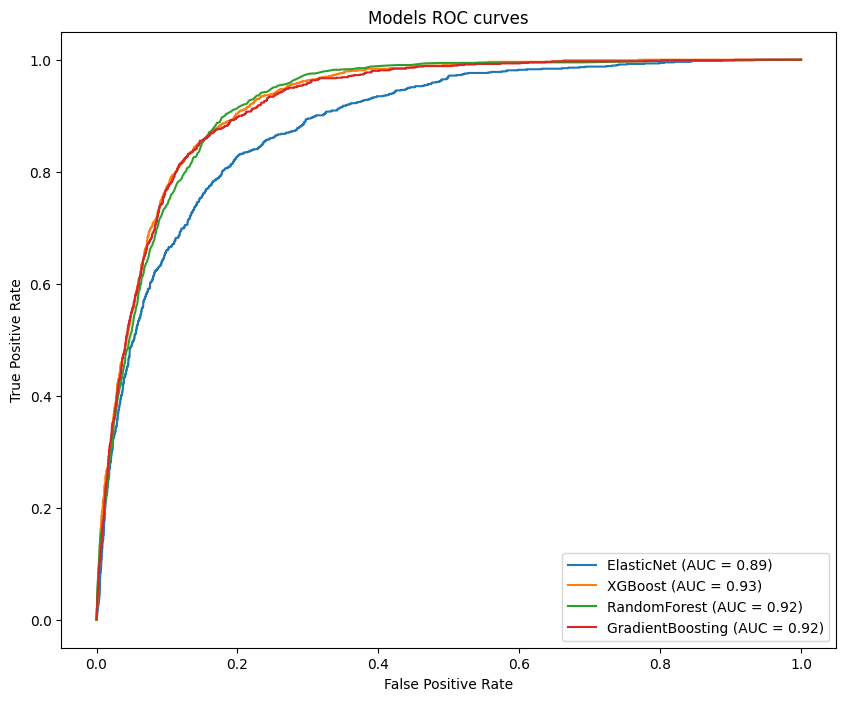


Best overall model: XGBoost with ROC AUC: 0.996900


In [16]:
# Inicializar el gráfico de la curva ROC
plt.figure(figsize=(10, 8))

# k-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Diccionarios para almacenar resultados
results = {}
best_models = {}
best_scores = {}

for model_name, model in models.items():
    print(f'Training {model_name}...')

    # Grid Search con validación cruzada
    grid_search = GridSearchCV(model, param_grids[model_name], cv=kf, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_resample[X_filtered], y_resample)

    best_models[model_name] = grid_search.best_estimator_
    best_scores[model_name] = grid_search.best_score_

    print(f'Best params for {model_name}: {grid_search.best_params_}')
    print(f'Best ROC AUC score for {model_name}: {grid_search.best_score_:.6f}')

    # Hacer predicciones en el conjunto de prueba con el thresholh de 0.4
    y_prob = best_models[model_name].predict_proba(X_test[X_filtered])[:, 1]
    threshold = 0.4
    y_pred = (y_prob >= threshold).astype(int)

    # Confusion matrix en el conjunto de prueba
    conf_matrix = confusion_matrix(y_test, y_pred)
    actual_negatives = conf_matrix[0].sum()
    actual_positives = conf_matrix[1].sum()

    false_positive = conf_matrix[0][1]  # Error Tipo I
    false_negative = conf_matrix[1][0]  # Error Tipo II

    false_positive_pct = (false_positive / actual_negatives) * 100
    false_negative_pct = (false_negative / actual_positives) * 100

    # Guardar resultados en el diccionario
    results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Type I Error (%)': false_positive_pct,
        'Type II Error (%)': false_negative_pct,
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Best Params': grid_search.best_params_
    }

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {results[model_name]['ROC AUC']:.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Models ROC curves')
plt.legend()
plt.show()

# Seleccionar el mejor modelo basado en la métrica ROC AUC
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]
print(f'\nBest overall model: {best_model_name} with ROC AUC: {best_scores[best_model_name]:.6f}')


In [17]:
# Convertir resultados a DataFrame y mostrar
results_df = pd.DataFrame.from_dict(results, orient='index').sort_values(by='ROC AUC', ascending=False)
print("\nResultados finales:")
results_df


Resultados finales:


,Accuracy,Precision,Recall,F1 Score,Type I Error (%),Type II Error (%),ROC AUC,Best Params
XGBoost,0.888864,0.517197,0.753308,0.613313,9.317470,24.669187,0.925315,"{'colsample_bytree': 0.6, 'learning_rate': 0.3..."
RandomForest,0.851487,0.431060,0.842155,0.570240,14.727614,15.784499,0.923345,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
GradientBoosting,0.887427,0.512920,0.750473,0.609363,9.442705,24.952741,0.922282,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti..."
ElasticNet,0.773748,0.322685,0.849716,0.467742,23.631810,15.028355,0.886278,"{'C': 100, 'l1_ratio': 0.9, 'penalty': 'elasti..."


In [ ]:
y_pred = best_models['RandomForest'].predict(X_test[X_filtered])
y_prob = best_models['RandomForest'].predict_proba(X_test[X_filtered])[:, 1]

# Confusion matrix en el conjunto de prueba
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print ('[[TN  FP] \n [FN  TP]]')

[[7091  894]
 [ 241  817]]
[[TN  FP] 
 [FN  TP]]


### Red Neuronal

In [ ]:
# Función para construir el modelo
def build_model(input_shape, learning_rate, dropout_rate, units, activation, hidden_layers):
    model = Sequential()
    model.add(Dense(units, activation=activation, input_shape=(input_shape,)))
    model.add(Dropout(dropout_rate))
    
    for _ in range(hidden_layers - 1):  
        model.add(Dense(units, activation=activation))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['AUC'])
    return model


In [ ]:
# Parámetros de la red neuronal
params = {'learning_rate': 0.001, 'dropout_rate': 0.2, 'units': 128, 'activation': 'relu', 'hidden_layers': 3}

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [21]:
# Construcción y entrenamiento del modelo
model = build_model(input_shape=X_train.shape[1], **params)

history = model.fit(
    X_train, Y_train,
    epochs=50, batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Predicciones en el conjunto de validación
y_true = Y_val
y_pred = (model.predict(X_val) > 0.5).astype(int).ravel()
y_prob = model.predict(X_val).ravel()

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8262 - loss: 0.4895 - val_AUC: 0.9596 - val_loss: 0.2614
Epoch 2/50
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9525 - loss: 0.2761 - val_AUC: 0.9650 - val_loss: 0.2363
Epoch 3/50
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9622 - loss: 0.2456 - val_AUC: 0.9685 - val_loss: 0.2221
Epoch 4/50
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9656 - loss: 0.2337 - val_AUC: 0.9689 - val_loss: 0.2214
Epoch 5/50
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9675 - loss: 0.2254 - val_AUC: 0.9727 - val_loss: 0.2011
Epoch 6/50
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9703 - loss: 0.2147 - val_AUC: 0.9721 - val_loss: 0.2284
Epoch 7/50
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9731 - loss: 0.2051 - val_AUC: 0.9747 - val_loss: 0.1911
Epoch 8/50
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - AUC: 0.9741 - loss: 0.2004 - val_AUC: 0.9752 - val_loss: 0.1915
Epoch 9/50
1338/1338 ━━━━━━━━━━━━━━━━━

In [22]:
# Cálculo de métricas
conf_matrix = confusion_matrix(y_true, y_pred)
actual_negatives = conf_matrix[0].sum()
actual_positives = conf_matrix[1].sum()

false_positive = conf_matrix[0][1]  # Error Tipo I
false_negative = conf_matrix[1][0]  # Error Tipo II

false_positive_pct = (false_positive / actual_negatives) * 100
false_negative_pct = (false_negative / actual_positives) * 100

roc_auc = roc_auc_score(y_true, y_prob)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Diccionario de resultados
results = {
    'Neural Network': {
        'ROC AUC': roc_auc,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Type I Error': false_positive_pct,
        'Type II Error': false_negative_pct
    }
}

In [23]:
# Mostrar tabla de métricas
df_results = pd.DataFrame(results).T
df_results

,ROC AUC,Accuracy,Precision,Recall,F1 Score,Type I Error,Type II Error
Neural Network,0.979631,0.939632,0.927126,0.960732,0.94363,8.377686,3.926795


In [27]:
print(conf_matrix)
print ('[[TN  FP] \n [FN  TP]]')

[[4648  425]
 [ 221 5407]]
[[TN  FP] 
 [FN  TP]]


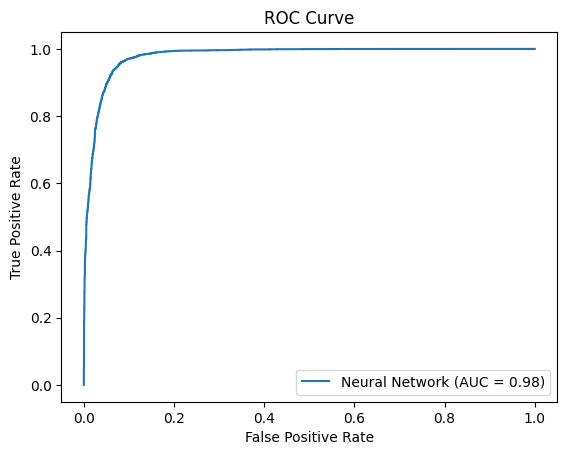

In [24]:
# Graficar curva ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.plot(fpr, tpr, label=f"Neural Network (AUC = {roc_auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

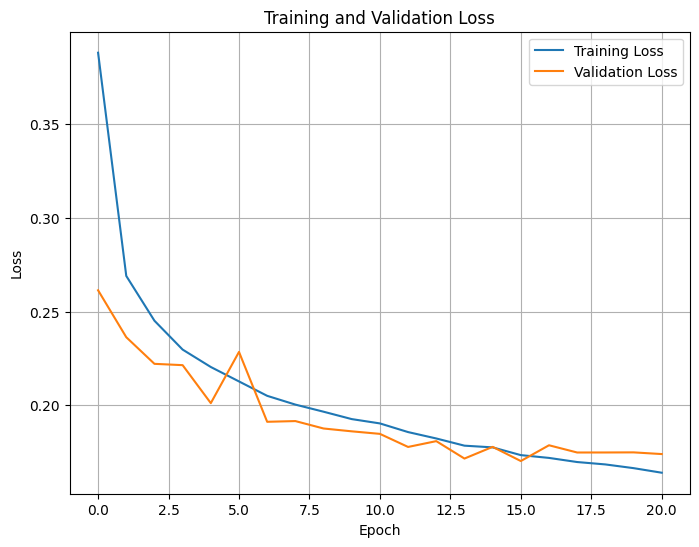

In [26]:
import matplotlib.pyplot as plt

# Suponiendo que ya entrenaste el modelo y tienes 'history'
# Graficar la pérdida (loss)
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()